<h1>How to fit SPI-light data with Stan</h1>

<h3>Usual imports</h3>

In [705]:
# Template for weird data space model fitting with Stan
# Example: fitting "SPI-light" data to a model of background sky
import numpy as np
import matplotlib.pyplot as plt
import stan_utility
import pystan
import pickle
import sys
import time # for testing how long things take
from IPython.display import Image
#plt.style.use('thomas')

<h3>"SPI-light" is a hypothetical instrument with two detectors which are blocked from the source photons, alternatingly for each pointing.<br>
    The background is (chosen) to be uniform.<br>
    A sketch of the setup is shown below.<br>
    We ignore the complicating factors of aspect angle, energy dependence, different observation times, and detector resolution for simplicity and only deal with photons per unit pointing. This resembles a counting experiment of "something per interval", an thus follows the Poisson distribution.</h3>

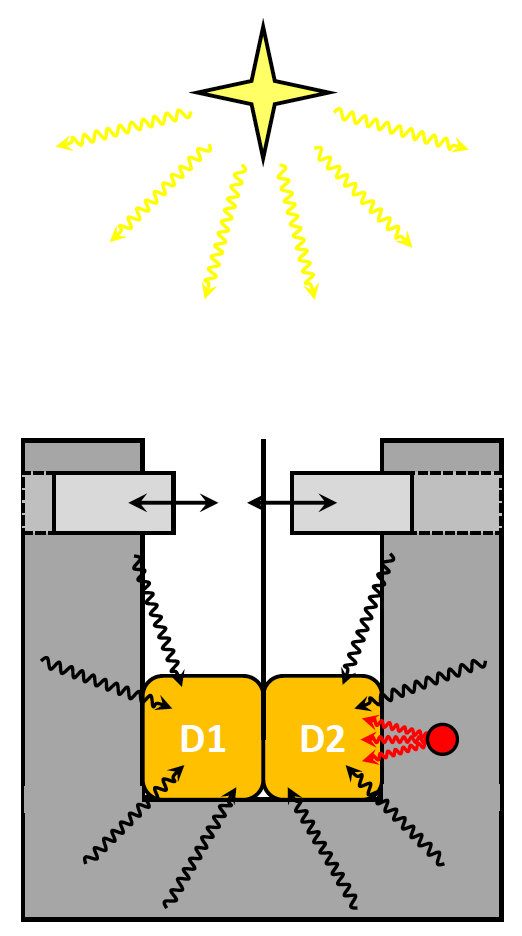

In [647]:
#plt.figure(figsize=(8,16))
with open('SPIlight.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h3>The data in this example are modelled by the following function:<br><br>
    $f(p) = \alpha \cdot R_{SKY}(p) + \beta \cdot B_{BG}$,<br><br>
    where $\alpha / (T_p \cdot A_{eff}) = F$ is the flux in units of $\mathrm{ph\,cm^{-2}\,s^{-1}}$ that we are interested in. Since we deal with unit pointings (not changing in time and independent of energy), we absorb the factor $(T_p \cdot A_{eff})$, i.e. the observation time per pointing $T_p$ and the effective area $A_{eff}$ of how much collecting area the instrument actually has for our photons, into the sky response $R_{SKY}(p)$. The sky response is typically determined via particle physics simulations and cross-checked via calibrations in Earth.<br>
    The background response $R_{BG}$ is a priori unknown and in general has to be extracted from the data themselves. Here, we create it first, use it, and later show how to reconstruct it from the data. As you can see, the background response is independent of the pointing number, which is the only factor that distinguishes it from the sky.<br>
    We define $R_{BG} = \begin{pmatrix}1 \\ 1\end{pmatrix}$, which defines how the background "looks" like, not how strong it is. The absolute scaling of the background is determined by the multiplicative factor $\beta$ that determines the number of photons in each detector. We will fit for $F$ ($\alpha$) and $\beta$, just as in the straight line case, but now with more complicated functions.<br>
    (In the function below the call with the pointing $p$ just defines the length of the final appearance.)</h3>

<h5>Background response</h5>

In [648]:
def R_BG(p): # pointing p
    return np.repeat(np.array([1.,1.]),len(p)).reshape(2,len(p)).T

<h3>The sky response then takes the form as described above, alternating between zero in detector 1 and one in detector 2 for odd numbered pointings and vice versa for even numbered pointings:
    <br>$R_{SKY}(p) = \begin{pmatrix}1 + (-1)^{p+1} \\ 1 + (-1)^p\end{pmatrix}$.

<h5>Sky response</h5>

In [649]:
def R_SKY(p): # pointing p
    A_eff = 10. # effective area in cm^2
    T_p = 100.  # time in each pointing in s
    return A_eff*T_p*np.array([1+(-1)**(p+1),1+(-1)**(p)]).T

<h5>Note the difference between background and sky response is that the R_BG is independent of p</h5>

<h3>Similar to the straight-line case, we define our data set, create a true model, draw a sample from it, and then fit it again to check if we get out what we put in.</h3>

<h5>We define 10 observation pointings 0..9</h5>

In [650]:
Np = 10
p = np.arange(Np)

<h5>What do the responses look like?</h5>

In [651]:
R_SKY(p).shape,R_BG(p).shape

((10, 2), (10, 2))

<h5>10 values for each of the 2 detectors</h5>

<h5>Define a plotting function for this type of data:</h5>

In [652]:
def SPIl_plot(p,
              y,color='black',label=None,
              y2=None,color2='red',label2=None,
              y3=None,color3='red',label3=None):
    pp = np.sort(np.concatenate([p-0.5,p+0.5])) # array for plotting
    plt.step(pp,y.ravel(),color=color,label=label,where='mid') # plotting the first array in histogram mode
    if np.any(y2 != None): # second array
        plt.step(pp,y2.ravel(),color=color2,label=label2,where='mid')
    if np.any(y3 != None): # third array
        plt.step(pp,y3.ravel(),color=color3,label=label3,where='mid')
    for i in range(len(p)+1): # drawing the boundaries of pointings to distinguish them
        plt.axvline(i-0.5,linestyle='--',color='black',alpha=0.5)
    plt.xlabel('Pointing number')
    plt.ylabel('Counts')
    plt.legend()

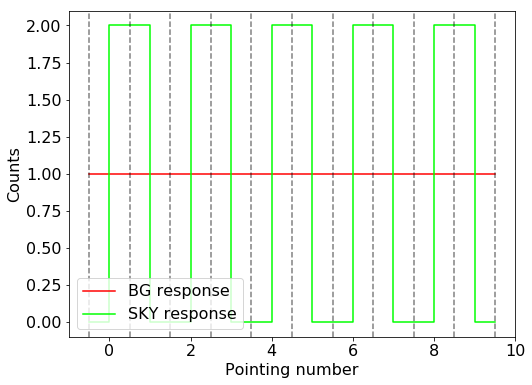

In [653]:
SPIl_plot(p,
          R_BG(p)/np.mean(R_BG(p)),color='red',label='BG response',
          y2=R_SKY(p)/np.mean(R_SKY(p)),color2='lime',label2='SKY response')

<h5>Here, each pair of vertical lines defines one pointing in which the background response (red) predicts 1 count in each detector.<br>
    The sky response predicts either 0 and 2 in a pointing (even numbered) or 2 and 0 (odd numbered).</h5>

<h5>Now create data</h5>

<h3>Note that we do not know exactly how the background is created and thus cannot assign a physical unit to $\beta$ so it stays unitless and just defines the number of counts.</h3>

In [657]:
true_sky = 1.25e-3 # ph / cm2 / s
true_bg = 30    # counts

# our true model
y_true = true_sky*R_SKY(p) + true_bg*R_BG(p)

# now drawing a Poisson sample
yp = np.random.poisson(y_true)

In [662]:
y_true # values for D1 (left) and D2 (right)

array([[30. , 32.5],
       [32.5, 30. ],
       [30. , 32.5],
       [32.5, 30. ],
       [30. , 32.5],
       [32.5, 30. ],
       [30. , 32.5],
       [32.5, 30. ],
       [30. , 32.5],
       [32.5, 30. ]])

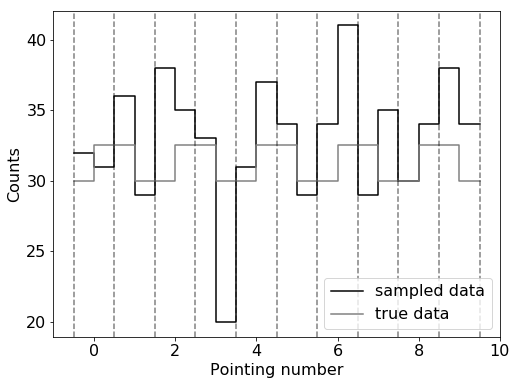

In [658]:
SPIl_plot(p,
          yp,color='black',label='sampled data',
          y2=y_true,color2='gray',label2='true data')

<h3>Since our data are Poisson distributed, we can not "add noise" to our true data since we can only measure whole photons, and the "32.5" counts that we predict in our true model are in fact the rate per unit pointing per unit detectorr that we expect - <em>not</em> the number of photons.<br><br>
    Given a model (value) $m$, the probability to observe $d$ photons is determined by the Poisson distribution,<br><br>
    $P(m|d) = \frac{m^d \exp(-m)}{d!}$,<br><br>
    so that for this particular case of $m = 32.5$, we expect the following distribution:</h3>

In [686]:
from scipy.stats import poisson # importing scipy to not calculate everything by hand

Text(0.5, 0, 'd')

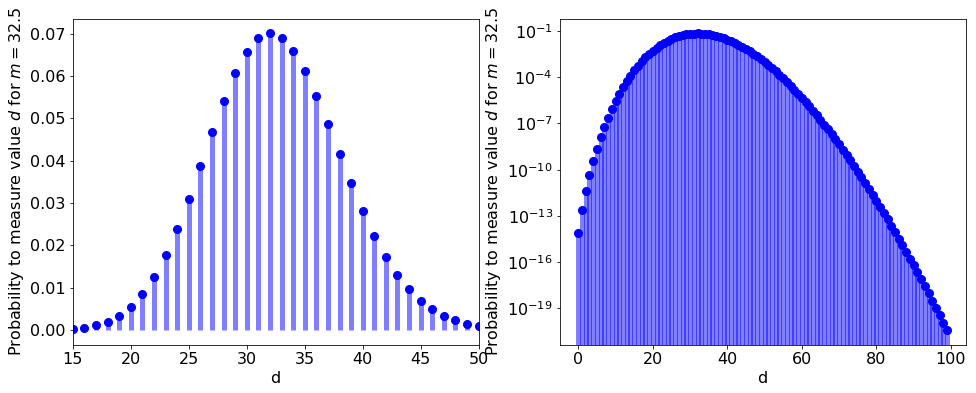

In [688]:
m = 32.5
x = np.arange(0,100)
#x = np.arange(poisson.ppf(0.01, m),poisson.ppf(0.99, m))

plt.figure(figsize=(16,6))
plt.subplot(121)

plt.plot(x, poisson.pmf(x, m), 'bo', ms=8, label='poisson pmf')
plt.vlines(x, 0, poisson.pmf(x, m), colors='b', lw=5, alpha=0.5)
plt.xlim(15,50)
plt.ylabel(r'Probability to measure value $d$ for $m = 32.5$')
plt.xlabel('d')

plt.subplot(122)
plt.plot(x, poisson.pmf(x, m), 'bo', ms=8, label='poisson pmf')
plt.vlines(x, 0, poisson.pmf(x, m), colors='b', lw=5, alpha=0.5)
plt.yscale('log')
plt.ylabel(r'Probability to measure value $d$ for $m = 32.5$')
plt.xlabel('d')

<h3>Both plots are showing the same distribution: Given a value $m = 32.5$, what is the probability to observe $d$ photons? Also note the asymmetry. It is in fact no where zero, just a very small probability, but of course peaking around 32.5.<br>Where is it maximal?</h3>

In [694]:
poisson.pmf([31,32,33,34,35],32.5)

array([0.06899089, 0.07006887, 0.06900723, 0.06596279, 0.06125116])

<h3>The most probable value for a rate of $m = 32.5$ is $d = 32$, <em>not</em> $33$ as could be naively expected from "rounding".<br>
    Consider a rate of $m = 0.9$, what value would you expect to see the most? What is the probability to observe $d = 3.4$?</h3>

In [699]:
poisson.pmf([0,1,2,3.4],.9)

array([0.40656966, 0.36591269, 0.16466071, 0.        ])

<h3>Drawing a Poisson sample now means we use the rate (expectation) in each data point (all pointings and all detectors) and pick an integer number according to how often the Poisson distribution predicts it.<br>
    This creates one realisation of our data set.</h3>

<h3>Like in the straight line case, we load our Stan model. This is a bit more complicated because it takes into account multiple background parameters if need be, instead of creating a different Stan model for all possible combinations.</h3>

In [700]:
"""## compile model (if not yet compiled):
model = pystan.StanModel('spimodfit.stan')

## save it to the file 'filename.pkl' for later use
with open('spimodfit.pkl', 'wb') as f:
    pickle.dump(model, f)"""
    
#read filename.pkl (if already compiled)
model = pickle.load(open('spimodfit.pkl', 'rb'))

<h5>We used python functions to create the data, now we use our known responses to input to the fit:</h5>

<h5>For our background model to work, we have to identify and transfer change points (if any). This is done by the following function.</h5>

In [568]:
def make_bg_cuts(cuts,Np):
    cuts = [1] + cuts + [1e99]
    cuts = list(np.unique(cuts))
    bg_cuts = np.zeros(Np)
    cidx = 0
    for i in range(1,Np+1):
        #print(i)
        if (cuts[cidx] <= i < cuts[cidx+1]):
            bg_cuts[i-1] = cuts[cidx]
        else:
            cidx += 1
            bg_cuts[i-1] = cuts[cidx]
            
    Ncuts = len(np.unique(bg_cuts))
    idx_arr = np.ones(Np)
    for i in range(Ncuts):
        idx_arr[np.where(bg_cuts == cuts[i])[0]] = i+1
    
    return bg_cuts.astype(int), idx_arr.astype(int), Ncuts

<h3>We will be cutting the background into pieces to check how many parameters $\beta_1$, $\beta_2$, $\beta_3$, ..., we actually need. This function simply converts the cutting points into something our Stan model needs.</h3>

<h5>Two examples for comprehension:</h5>

In [701]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np) # for 10 pointings, use only one time node (== constant BG)
# (python's first index is zero, Stan's is 1 (!))

In [702]:
bg_cuts,idx_arr,Ncuts

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 1)

In [703]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1,3,8],Np) # for 10 pointings, use three time nodes at 1,3,8
bg_cuts,idx_arr,Ncuts

(array([1, 1, 3, 3, 3, 3, 3, 8, 8, 8]),
 array([1, 1, 2, 2, 2, 2, 2, 3, 3, 3]),
 3)

<h3>This means, the time bins (pointings) 1 2 get the same parameter with the index 1, the time bins 3, 4, 5, 6, and 7, all get the same parameter with index 2, and the time bins 8, 9, and 10 get a parameter with index 3.<br>We keep it as one parameter in the following.</h3>

In [704]:
Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np)

# dictionary for data set and prior
# the functional form of R_SKY and R_BG is given to the Stan model directly
# in the straight line case, we let that calculate inside the Stan model, because it was "easy"
data2D = dict(N = Nrsp, # number of response entries (here: number of detectors)
              Np = Np,  # number of pointings
              Nsky = 1, # number of sky models
              Ncuts = Ncuts,        # number of background cuts
              bg_cuts = bg_cuts,    # which cuts are made
              bg_idx_arr = idx_arr, # indices for cuts
              y = yp.ravel().astype(int),             # dataset (reformatting required)
              bg_model = R_BG(p),                     # background moddel
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # sky model (reformatting required)
              mu_flux = mu_flux_scl,         # prior centroid flux (alpha)
              sigma_flux = sigma_flux_scl,   # prior width flux 
              mu_Abg = mu_Abg,               # prior centroid background scaling (beta)
              sigma_Abg = sigma_Abg)         # prior width background scaling

<h5>Now, let's only optimise the posterior and plot the result:</h5>

<h5>Optimisation <em>might</em> need a good starting point to find the maximum of the posterior, so we give it good values. For the sampling, this is not important.</h5>

In [708]:
init = {} 
init['flux'] = np.array([1e-3])
init['Abg'] = np.repeat(30,Ncuts)
start = time.time()
op = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
print('Time taken for fit %.3f s.' % (time.time()-start))
op

Time taken for fit 0.001 s.


OrderedDict([('par',
              OrderedDict([('flux', array(0.00180224)),
                           ('Abg', array(31.19569503)),
                           ('model_values',
                            array([31.19569503, 34.80017969, 34.80017969, 31.19569503, 31.19569503,
                                   34.80017969, 34.80017969, 31.19569503, 31.19569503, 34.80017969,
                                   34.80017969, 31.19569503, 31.19569503, 34.80017969, 34.80017969,
                                   31.19569503, 31.19569503, 34.80017969, 34.80017969, 31.19569503])),
                           ('ppc',
                            array([32., 42., 31., 29., 29., 40., 35., 30., 31., 31., 37., 27., 45.,
                                   42., 37., 33., 29., 37., 29., 37.])),
                           ('model_tot',
                            array([65.99587472, 65.99587472, 65.99587472, 65.99587472, 65.99587472,
                                   65.99587472, 65.99587472, 65.9958747

<h5>The result dictionary (op) includes all the information that we generated in the Stan model.<br>
    The PPC and posterior models don't make much sence without the posterior distributions, but we get a value for the flux and the background amplitude (again, without uncertainties):</h5>

In [709]:
fitted_model = op['par']['model_values'].reshape((Np,Nrsp))

In [710]:
fitted_model.shape

(10, 2)

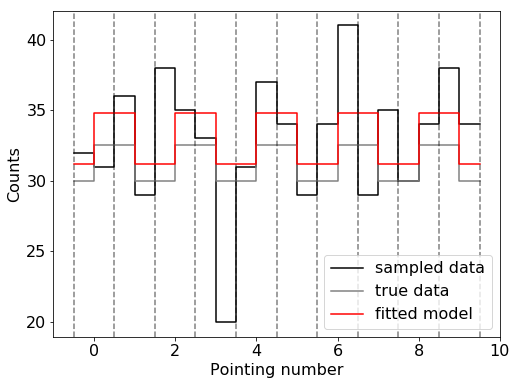

In [711]:
SPIl_plot(p,
          yp,color='black',label='sampled data',
          y2=y_true,color2='gray',label2='true data',
          y3=fitted_model,color3='red',label3='fitted model')

<h5>Magic? Slightly off? Let's check out the sampling to determine our uncertainties and find of the model actually predicts our data:</h5>

In [712]:
op2 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg']

In [713]:
op2

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]          2.0e-3  4.9e-5 1.2e-3 1.3e-4 1.1e-3 1.8e-3 2.7e-3 4.5e-3    555    1.0
Abg[1]            31.16    0.07   1.67  27.58  30.11  31.18  32.32  34.29    562    1.0
model_values[1]   31.16    0.07   1.67  27.58  30.11  31.18  32.32  34.29    562    1.0
model_values[2]    35.1    0.05   1.79  31.82  33.81   35.0  36.29  38.82   1466    1.0
model_values[3]    35.1    0.05   1.79  31.82  33.81   35.0  36.29  38.82   1466    1.0
model_values[4]   31.16    0.07   1.67  27.58  30.11  31.18  32.32  34.29    562    1.0
model_values[5]   31.16    0.07   1.67  27.58  30.11  31.18  32.32  34.29    562    1.0
model_values[6]    35.1    0.05   1.79  31.82  33.81   35.0  36.29  38.82   1466    1.0
model_values[7]    

<h5>This is a lot of information.<br>
    Let's walk through this:<br>
    flux[1] and Abg[1] are our parameters of interest with fitted (mean or median (= 50% percentile)) value and uncertainty (e.g. standard deviation of the posterior distribution (sd) or whatever percentile you like).<br>
    model_values[1..20] are the fitted model values for each data point (!) with their respective uncertainties from the fitted parameters, their uncertainties, and the data.<br>
    ppc[1..20] are the posterior predictive values (= new data drawn from the model values) for each data points.<br>
    model_tot[1..10] are the total model counts, summed over the data space bins (here 2 detectors), i.e. the total number of photons per pointing.<br>
    model_bg[1..10] and model_sky[1..10] are the same as model_tot[1..0] but split into the individual model components.<br>
    Finally, lp__ is the log-posterior of the fit.</h5>

<h3>One example of the PPC right away because we only have 20 data points and can draw all of them. For each data points, we get sample of "new" data points, given the model and the data generating process (Poisson distribution), so that we can (and if possible should) check each data point for its consistency:</h3>

In [717]:
op2['ppc'].shape

(2500, 20)

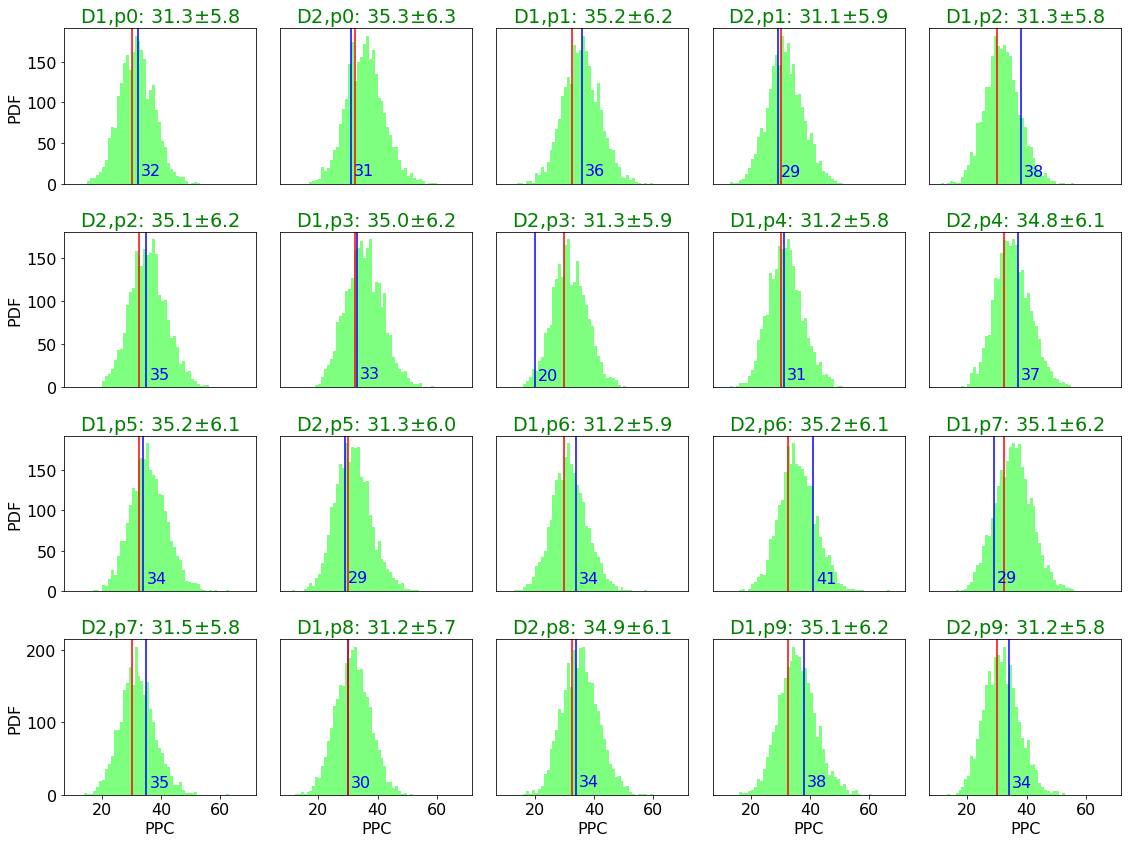

In [776]:
fig, ax = plt.subplots(nrows=4,ncols=5,figsize=(16,12))
for i in range(4):
    for j in range(5):
        ax[i,j].hist(op2['ppc'][:,i*5+j],bins=np.arange(10,70,1),color='lime',alpha=0.5)
        ax[i,j].axvline(yp.ravel()[i*5+j],color='blue')
        ax[i,j].text(yp.ravel()[i*5+j]+1,10,str(yp.ravel()[i*5+j]),color='blue')
        ax[i,j].set_title(r'D%1i,p%1i: %.1f$\pm$%.1f' % (((-1)**(i*5+j+1)+1)/2+1,
                                                        np.abs(np.ceil(((i*5+j-1)/2))),
                                                        np.mean(op2['ppc'][:,i*5+j]),
                                                        np.std(op2['ppc'][:,i*5+j])),color='green')
        ax[i,j].axvline(y_true.ravel()[i*5+j],color='red')
        if i != 3:
            ax[i,j].set_xticks([])
        else:
            ax[i,j].set_xlabel('PPC')
        if j != 0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_ylabel('PDF')
plt.tight_layout()

<h3>Don't worry about the details how this plot is created. What is important is the following: For each individual data points (vertical blue lines) for each Detector (D) and pointing (p) combination we get a complete distribution (green) of what future data might look like. We can compare the data value (blue annotation) with the mean and standard deviation of future data (title of each plot), and see that all work fine (just as expected from the correct handling of our data). We can also compare it to our true model rates (red vertical lines) as these should also fall inside these distributions.<br>
    Have a closer look at the case D2,p3: Here, our sampled value in the data set is 20. In fact this is on the low side of the expectation from the PPC, which predicts a distribution around 31.3. This value is <em>much</em> closer to the true model rate as indicated by the red line. This nicely shows how we can check if we do something wrong.</h3>

<h3>Once our data set is not as lucid as in this case, we have to rely on summary statistics, for example in this case, plotting the PPC as a function of time, or summing over time and plotting as a function of detector.</h3>

<h5>Now, what do our posterior distributions for flux and Abg look like?</h5>

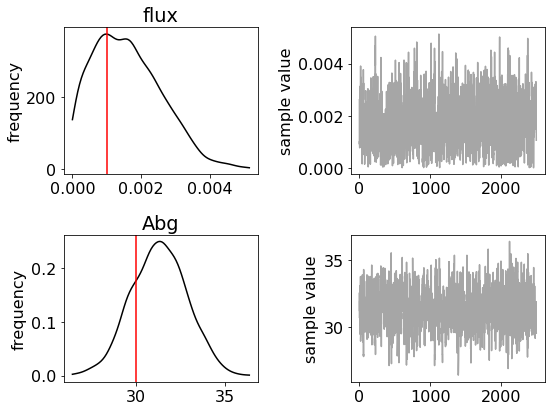

In [501]:
pl = op2.plot(['flux','Abg']);
pl.axes[0].axvline(true_sky,color='red')
pl.axes[2].axvline(true_bg,color='red')
plt.tight_layout()

<h5>Clearly, our sky signal is not very "significant" (why?). Still, we meet our true values (red lines) quite nicely. We will improve the signal-to-noise ratio later in the notebook.</h5>

<h5>PPCs of complete data set (all data points in another way):</h5>

In [777]:
pp = np.sort(np.concatenate([p-0.5,p+0.5])) # array for plotting

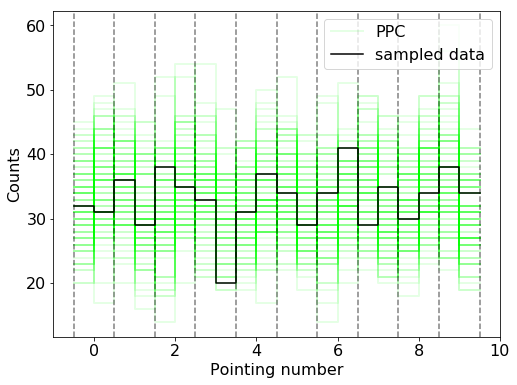

In [778]:
for i in range(0,2500,25):
    plt.step(pp,op2['ppc'][i,:],
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(pp,op2['ppc'][i,:],alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC in only time domain (summary statistics by summing over the detectors [here, axis=1])</h5>

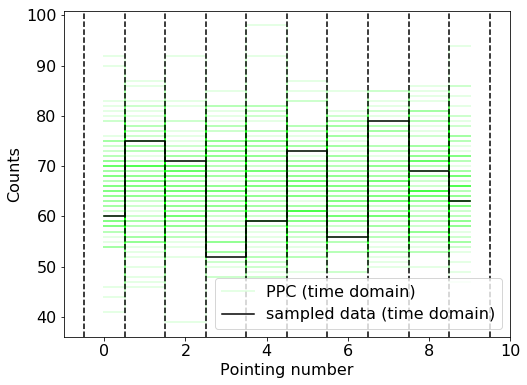

In [504]:
for i in range(0,2500,25):
    plt.step(p,np.sum(op2['ppc'][i,:].reshape((Np,Nrsp)),axis=1),
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(p,np.sum(op2['ppc'][i,:].reshape((Np,Nrsp)),axis=1),alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC (time domain)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data (time domain)',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend()

<h5>Model posterior (all data points)<br>
    (Do you understand the difference? If not, have a look again at the straight line case!)</h5>

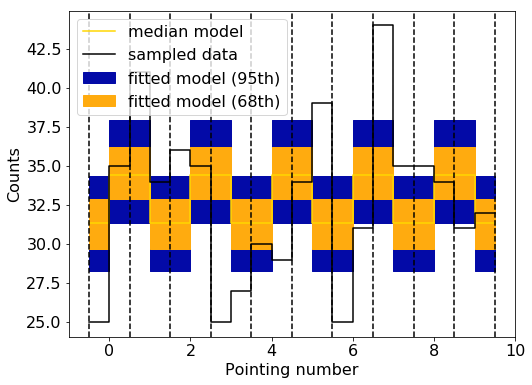

In [505]:
plt.step(pp,np.percentile(op2['model_values'],50,axis=0),color='gold',where='mid',label='median model')

plt.fill_between(pp,
         np.percentile(op2['model_values'],50-95.4/2,axis=0),
         np.percentile(op2['model_values'],50+95.4/2,axis=0),
                 step='mid',color='xkcd:cobalt blue',alpha=1.0,label='fitted model (95th)')

plt.fill_between(pp,
         np.percentile(op2['model_values'],50-68.3/2,axis=0),
         np.percentile(op2['model_values'],50+68.3/2,axis=0),
                 step='mid',color='xkcd:yellowish orange',alpha=1.0,label='fitted model (68th)')


SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>Model posterior (individual components, only time domain):</h5>

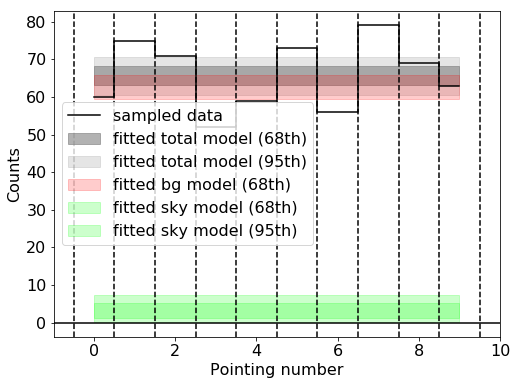

In [506]:

plt.fill_between(p,
         np.percentile(op2['model_tot'],50-68.3/2,axis=0),
         np.percentile(op2['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op2['model_tot'],50-95.4/2,axis=0),
         np.percentile(op2['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op2['model_bg'],50-68.3/2,axis=0),
         np.percentile(op2['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op2['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op2['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')
plt.fill_between(p,
         np.percentile(op2['model_sky'],50-95.4/2,axis=(0,1)),
         np.percentile(op2['model_sky'],50+95.4/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (95th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

plt.axhline(0)

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=6)

<h5>Example with scaling every pointing:</h5>

In [779]:
Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (note that only this one changed)
#bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np)
bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(1,Np+1)),Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [780]:
op3 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg'])

In [781]:
op3

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1]          2.1e-3  3.0e-5 1.2e-3 1.5e-4 1.2e-3 2.0e-3 2.8e-3 4.6e-3   1520    1.0
Abg[1]            30.17    0.08   4.12  22.63  27.24  30.01  33.02  38.55   2710    1.0
Abg[2]            30.86    0.09   4.24  23.02  27.91  30.63  33.56   39.5   2282    1.0
Abg[3]            35.07    0.08   4.34  27.08  32.07  34.84  37.88  44.12   2743    1.0
Abg[4]            24.67    0.07   3.78  17.83  22.02  24.55  27.06  32.26   2797    1.0
Abg[5]            32.46    0.09   4.24  24.63  29.41  32.34  35.26  41.24   2363    1.0
Abg[6]            30.05    0.08   4.12  22.81   27.1  29.85  32.71  38.61   2399    1.0
Abg[7]            35.78    0.08    4.4  27.45  32.78   35.6  38.73  44.77   2703    1.0
Abg[8]            3

<h5>Now we have 10(!) background parameters, one for each pointing.</h5>

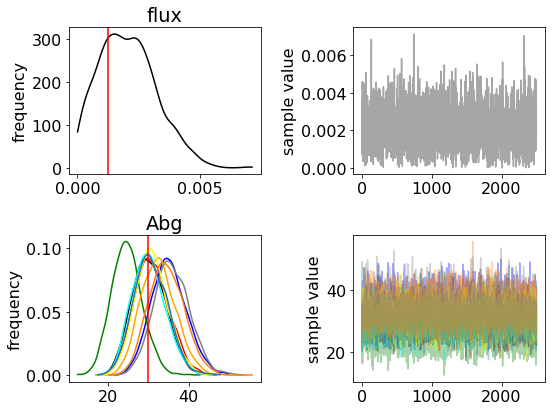

In [782]:
pl = op3.plot(['flux','Abg']);
pl.axes[0].axvline(true_sky,color='red')
pl.axes[2].axvline(true_bg,color='red')
plt.tight_layout()

<h3>Again, we see that we meeting our expectations, but do we really need 10 background parameters when they all coincide with the true value of 30?</h3>

<h5>Model posterior (all data points)</h5>

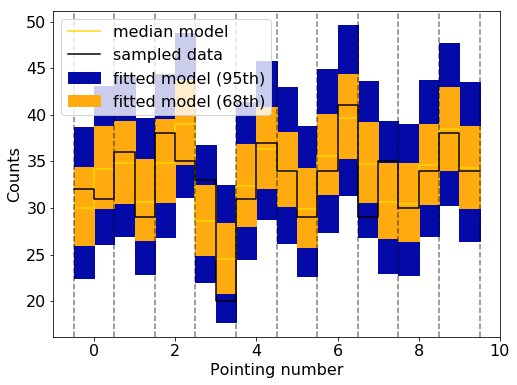

In [783]:
plt.step(pp,np.percentile(op3['model_values'],50,axis=0),color='gold',where='mid',label='median model')

plt.fill_between(pp,
         np.percentile(op3['model_values'],50-95.4/2,axis=0),
         np.percentile(op3['model_values'],50+95.4/2,axis=0),
                 step='mid',color='xkcd:cobalt blue',alpha=1.0,label='fitted model (95th)')

plt.fill_between(pp,
         np.percentile(op3['model_values'],50-68.3/2,axis=0),
         np.percentile(op3['model_values'],50+68.3/2,axis=0),
                 step='mid',color='xkcd:yellowish orange',alpha=1.0,label='fitted model (68th)')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC (all data points)</h5>

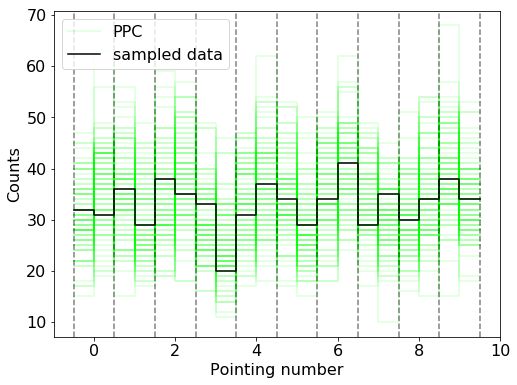

In [784]:
for i in range(0,2500,25):
    plt.step(pp,op3['ppc'][i,:],
             alpha=0.1,where='mid',color='lime',linewidth=2)
plt.step(pp,op3['ppc'][i,:],alpha=0.1,where='mid',color='lime',linewidth=2,label='PPC')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h5>PPC (time)</h5>

Text(0, 0.5, 'Counts')

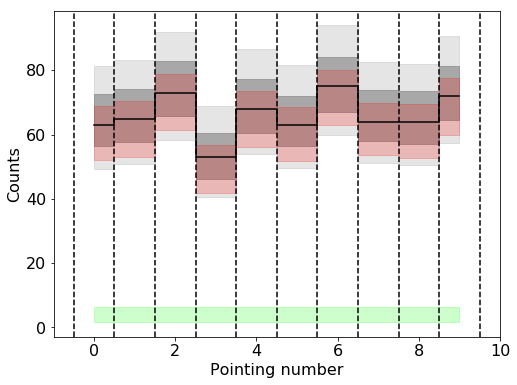

In [785]:
plt.fill_between(p,
         np.percentile(op3['model_tot'],50-68.3/2,axis=0),
         np.percentile(op3['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op3['model_tot'],50-95.4/2,axis=0),
         np.percentile(op3['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op3['model_bg'],50-68.3/2,axis=0),
         np.percentile(op3['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op3['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op3['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

for i in range(len(p)+1):
    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
#plt.legend(loc=6)

In [1013]:
Np = 10
p = np.arange(Np)

<h5>Did we overfit? How do we check that? What is optimal?</h5>

<h5>Let's define possible background time nodes (cuts), i.e. every 10, 5, 3, 2, 1 pointings:</h5>

In [1014]:
all_cuts = [list(range(1,Np+1,int(Np/i))) for i in list(range(1,Np+1))]
all_cuts_unique = np.unique(all_cuts)

all_cuts_unique

array([list([1]), list([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
       list([1, 3, 5, 7, 9]), list([1, 4, 7, 10]), list([1, 6])],
      dtype=object)

<h5>Here, we define the figure of merit "Cash statistic" (Cash 1979), i.e. the log-Poisson likelihood.<br>
    In addition, we define the Akaike Information Criterion (Akaike 1974) that penalises too many fitted parameters in a fit:</h5>

In [1015]:
def AIC(n_par, lnlik):
    return (2*n_par) - (2*lnlik)

def cashstat(data,model):
    return 2*np.sum(data*np.log(model)-model-(data*np.nan_to_num(np.log(data))-data))

def cstat(data,model):
    return 2*np.sum(data*np.log(model)-model)

<h5>Now we loop over all chosen background settings and record/calculate the cash stat (note: no sampling needed, the optimum point is enough):</h5>

In [1016]:
cstat_arr = []
for c in range(len(all_cuts_unique)):
    bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts_unique[c],Np)

    # dictionary for data set and prior
    data2D = dict(N = Nrsp,
                  Np = Np,
                  Nsky = 1,
                  Ncuts = Ncuts,
                  bg_cuts = bg_cuts,
                  bg_idx_arr = idx_arr,
                  y = yp.ravel().astype(int),
                  bg_model = R_BG(p),
                  conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
                  mu_flux = mu_flux_scl,
                  sigma_flux = sigma_flux_scl,
                  mu_Abg = mu_Abg,
                  sigma_Abg = sigma_Abg)
    
    init = {}
    init['Abg'] = np.repeat(1,Ncuts)
    init['flux'] = np.array([1e-3])
    op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
    cstat_arr.append(cashstat(yp.ravel(),op_tmp['par']['model_values']))
cstat_arr = np.array(cstat_arr)

<h5>Number of fitted parameters (note: also the sky model scaling counts):</h5>

In [1017]:
n_par_arr = np.zeros(len(all_cuts_unique))
for c in range(len(all_cuts_unique)):
    _, _, n_par_arr[c] = make_bg_cuts(all_cuts_unique[c],Np)
n_par_arr += 1

<h5>Sort array to get monotonic function (not required but can make visualisation easier):</h5>

In [1018]:
so = np.argsort(n_par_arr)
n_par_arr = n_par_arr[so]

Text(0, 0.5, 'AIC')

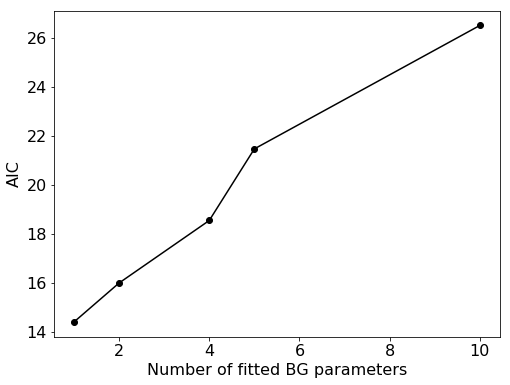

In [1019]:
plt.plot(n_par_arr-1,AIC(n_par_arr,cstat_arr[so]/2),'o-')
plt.xlabel('Number of fitted BG parameters')
plt.ylabel('AIC')

<h5>???<br>
    The absolute value of the AIC has (nearly) no meaning, only the relative values:<br>
    The lowest AIC is, among the tested scenarios, indicating the most probable model.<br>
    Here, this is the configuration with only one background scaling parameters.<br>
    This is expected as we included a constant background model, so, everything works as expected.</h5>

<h3>Example for Kalp to see that the AIC would have a minimum somewhere when we change the true background:<br>
    We use 60 pointings now, define another dataset, but set the background to change every 5 pointings. Then we repeat the case from above with the new data set and calculate the AIC.</h3>

<h5>New data set</h5>

In [1037]:
Np = 60
p = np.arange(Np)

<h5>All possible (actually not) background cuts to define a changing background model</h5>

In [1038]:
all_cuts = [list(range(1,Np+1,int(Np/i))) for i in list(range(1,Np+1))]
all_cuts_unique = np.unique(all_cuts)

all_cuts_unique

array([list([1]),
       list([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
       list([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59]),
       list([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58]),
       list([1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57]),
       list([1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56]),
       list([1, 7, 13, 19, 25, 31, 37, 43, 49, 55]),
       list([1, 8, 15, 22, 29, 36, 43, 50, 57]),
       list([1, 9, 17, 25, 33, 41, 49, 57]),
       list([1, 11, 21, 31, 41, 51]), list([1, 13, 25, 37, 49]),
       list([1, 16, 31, 46]), list([1, 21, 41]), list([1, 31])],
      dtype=object)

<h5>This once is what we want to have in the end as true one.</h5>

In [1039]:
all_cuts_unique[5]

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56]

<h5>These are 12 different* BG values. Let's assume the background changes as a sine function:</h5>

In [1040]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts_unique[5],Np)

In [1041]:
true_bg = 30 + 10*np.sin(np.unique(idx_arr))

Text(0, 0.5, 'Counts')

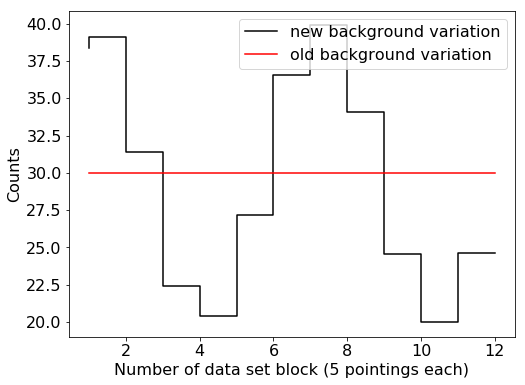

In [1042]:
plt.step(np.unique(idx_arr),true_bg,label='new background variation')
plt.step(np.unique(idx_arr),np.repeat(30,len(np.unique(idx_arr))),label='old background variation')
plt.legend()
plt.xlabel('Number of data set block (5 pointings each)')
plt.ylabel('Counts')

<h5>The following line is how this is implemented in the Stan model (reminder: Stan indices start at 1, Python at 0):</h5>

In [1043]:
y_true_bg = true_bg[idx_arr-1][:,None]*R_BG(p)

In [1044]:
true_sky = 1.25e-3 # ph / cm2 / s

# our true model
# sky part (as before)
y_true_sky = true_sky*R_SKY(p)
# background part (calculated above), so we just need to add the models
y_true = y_true_sky + y_true_bg

# now drawing a Poisson sample again
yk = np.random.poisson(y_true)

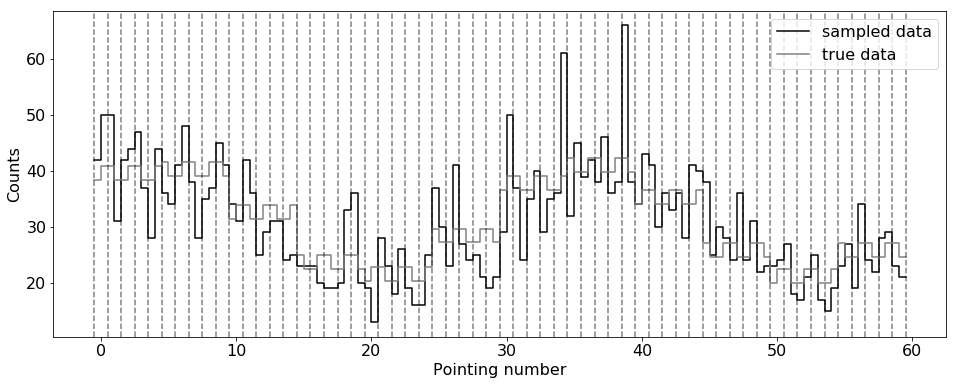

In [1045]:
plt.figure(figsize=(16,6))
SPIl_plot(p,
          yk,color='black',label='sampled data',
          y2=y_true,color2='gray',label2='true data')

<h3>We see already from the plot of the data that this does not contain a constant background.<br>
    Now we do the same analysis as before and test all background cut combinations that we defined, calculate the AIC, and plot the result.</h3>

In [1046]:
cstat_arr = []
n_par_arr = []
for c in range(len(all_cuts_unique)):
    Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
    N = Np*Nrsp
    
    bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts_unique[c],Np)

    # dictionary for data set and prior
    data2D = dict(N = Nrsp,
                  Np = Np,
                  Nsky = 1,
                  Ncuts = Ncuts,
                  bg_cuts = bg_cuts,
                  bg_idx_arr = idx_arr,
                  y = yk.ravel().astype(int),
                  bg_model = R_BG(p),
                  conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
                  mu_flux = mu_flux_scl,
                  sigma_flux = sigma_flux_scl,
                  mu_Abg = mu_Abg,
                  sigma_Abg = sigma_Abg)
    
    init = {}
    init['Abg'] = np.repeat(30,Ncuts)
    init['flux'] = np.array([1e-3])
    op_tmp = model.optimizing(data=data2D,verbose=True,init=init,as_vector=False,tol_rel_grad=1e4)
    cstat_arr.append(cashstat(yk.ravel(),op_tmp['par']['model_values']))
cstat_arr = np.array(cstat_arr)

n_par_arr = np.zeros(len(all_cuts_unique))
for c in range(len(all_cuts_unique)):
    _, _, n_par_arr[c] = make_bg_cuts(all_cuts_unique[c],Np)
n_par_arr += 1
so = np.argsort(n_par_arr)
n_par_arr = n_par_arr[so]

Text(0, 0.5, 'AIC')

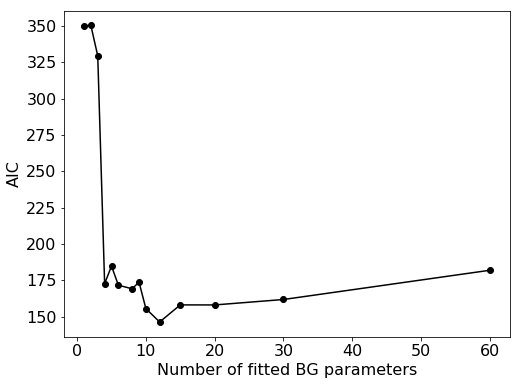

In [1047]:
plt.plot(n_par_arr-1,AIC(n_par_arr,cstat_arr[so]/2),'o-')
plt.xlabel('Number of fitted BG parameters')
plt.ylabel('AIC')
#plt.yscale('symlog',linthreshy=1e2)

<h3>(In fact, I found a sign error in the example above by doing this example, so, thank you.)<br>
    We see that we now found a clearly defined minimum for 12 background parameters, as expected from our input. There are also local minima and the (number of) parameter space is actually not very smooth. There are also more possibilities to define background cuts which I ignored here. For example, cutting at 1, 2, 3, then 34, 38, and 57, 58, 59, 60 would be a legitimate option for our machinery. However, such a combination might be unjustified (by whatever reason), and we stick to the cases "every pointing, every 2 poitings, every 3 pointings", etc.<br>
    A plot of the best fit set of background parameters when sampling the corresponding thing:</h3>

In [1055]:
Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# best fit combination
bg_cuts, idx_arr, Ncuts = make_bg_cuts(all_cuts_unique[5],Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yk.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [1056]:
opk = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg'])

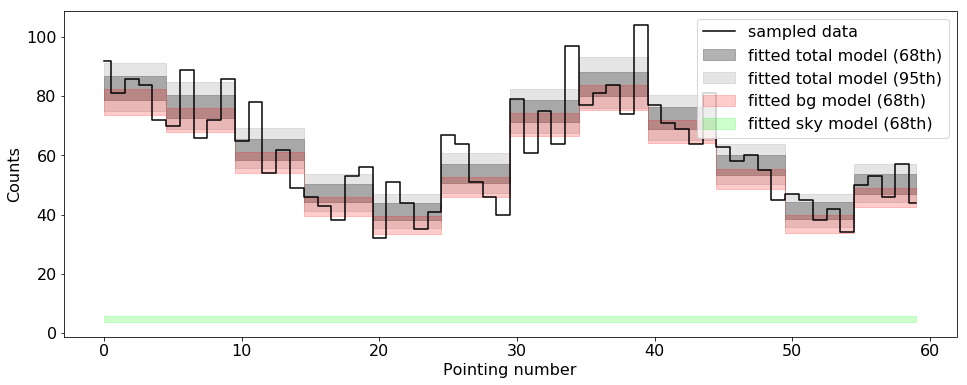

In [1061]:
plt.figure(figsize=(16,6))

plt.fill_between(p,
         np.percentile(opk['model_tot'],50-68.3/2,axis=0),
         np.percentile(opk['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(opk['model_tot'],50-95.4/2,axis=0),
         np.percentile(opk['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(opk['model_bg'],50-68.3/2,axis=0),
         np.percentile(opk['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(opk['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(opk['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yk,axis=1),color='black',label='sampled data',where='mid')

#for i in range(len(p)+1):
#    plt.axvline(i-0.5,linestyle='--',color='black')
plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=1)

<h3>Now, if we don't know the BG response but only the SKY response (from simulation, or ground measurements), can we extract the same information from the data themselves?</h3>

<h5>Sum data set over all times/pointings and create a background response (expected number of counts in data space bins, relative to each other, normalised to a common value, here number of detectors):</h5>

In [1082]:
# redefining the number of pointings again
Np = 10
p = np.arange(Np)
# and true background value
true_bg = 30

<h3>Axis "0" is the pointing domain, over which we sum over.</h3>

In [1083]:
yp.shape

(10, 2)

In [1084]:
yp # D1, D2

array([[32, 31],
       [36, 29],
       [38, 35],
       [33, 20],
       [31, 37],
       [34, 29],
       [34, 41],
       [29, 35],
       [30, 34],
       [38, 34]])

In [1085]:
np.sum(yp,axis=0) # sum from top to bottom in each column

array([335, 325])

In [1086]:
np.sum(yp,axis=0)/np.sum(yp)*2 # normalising to the total count rate and number of detectors
# this is in fact not required but provides a nice intuition of "change wrt 1.0"

array([1.01515152, 0.98484848])

In [1087]:
def R_BG_from_data(y,norm,p):
    return np.repeat(np.sum(y,axis=0)/np.sum(y)*norm,len(p)).reshape(2,len(p)).T

In [1088]:
R_BG_from_data(yp,2,p)[0,:],R_BG(p)[0,:] # reconstructed, original

(array([1.01515152, 0.98484848]), array([1., 1.]))

(0, 2)

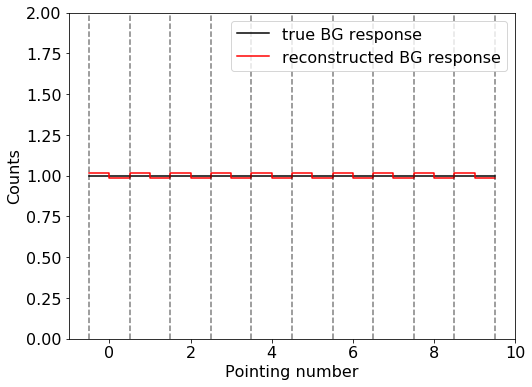

In [1089]:
SPIl_plot(p,R_BG(p),color='black',label='true BG response',
          y2=R_BG_from_data(yp,2,p),color2='red',label2='reconstructed BG response')
plt.ylim(0,2)

<h5>As you can see, the sky signal smears out, and the resulting BG response is nearly identical to what we would put in in the first place.<br>
    Now running through the fits and comparing results:</h5>

In [1090]:
# the only thing that is changed here is the background response, now being calculate from the data
# the rest stays the same
Np, Nrsp = R_BG_from_data(yp,2,p).shape         # initialise sizes of arrays
N = Np*Nrsp                                     # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([1],Np)
#bg_cuts, idx_arr, Ncuts = make_bg_cuts(list(np.arange(0,10,1)+1),Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG_from_data(yp,2,p),
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [1091]:
op4 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True,pars=['flux','Abg'])

In [1092]:
print(op4)

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 2.0e-3  4.1e-5 1.1e-3 1.6e-4 1.1e-3 1.9e-3 2.8e-3 4.4e-3    777    1.0
Abg[1]    31.1    0.06   1.63  27.99   30.0  31.07  32.16  34.36    734    1.0
lp__    1644.3    0.05   1.22 1641.0 1643.8 1644.7 1645.2 1645.5    528    1.0

Samples were drawn using NUTS at Fri Jul 17 22:00:38 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


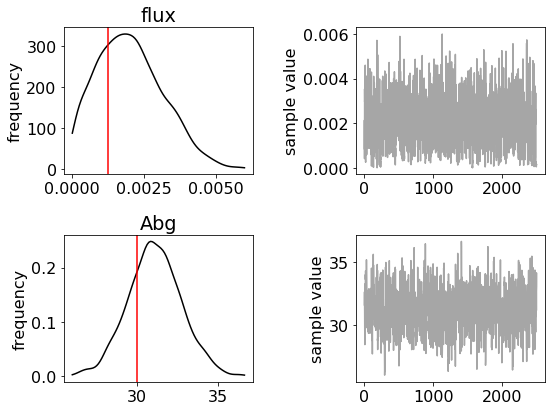

In [1093]:
pl = op4.plot()
pl.axes[0].axvline(true_sky,color='red')
pl.axes[2].axvline(true_bg,color='red')
plt.tight_layout()

In [1094]:
print('True BG response results: \nflux = %2.2f+-%2.2f; Abg = %2.2f+-%2.2f' %
      (np.mean(op2['flux'])*1e3,np.std(op2['flux'])*1e3,
      np.mean(op2['Abg']),np.std(op2['Abg'])))

True BG response results: 
flux = 1.97+-1.15; Abg = 31.16+-1.67


In [1095]:
print('Constructed BG response results: \nflux = %2.2f+-%2.2f; Abg = %2.2f+-%2.2f' %
      (np.mean(op4['flux'])*1e3,np.std(op4['flux'])*1e3,
      np.mean(op4['Abg']),np.std(op4['Abg'])))

Constructed BG response results: 
flux = 2.01+-1.13; Abg = 31.10+-1.63


In [1096]:
print('True values: \nflux = %2.2f; Abg = %2.2f' %
      (true_sky*1e3,true_bg))

True values: 
flux = 1.25; Abg = 30.00


<h3>We see that (in this realisation of the data), we over-estimate the true flux, however are still consistent with the expectation. Likewise, for the BG.<br><br>
    Now we want to increase our signal, which means we want to decrease our uncertainties. This can be done by more detecting area (larger instrument), more instruments observing the same thing, or observing for longer times (increasing the exposure time).</h3>

<h3>First, a heuristic example, why this helps:<br>
    Consider we observe for 100 time intervals (explicit number of seconds in interval doesn't matter), and we measure one photon from the sky in each interval, so that the cumulative counts $S(t) = t$. Consider further that we also measure background in interval at a constant rate, here 10, so that the cumulative counts $B(t) = 10 \cdot t + 10$. This means in the first interval, we only measure background, and no sky. Finally, the total counts in each time interval are just $T(t) = S(t) + B(t) = 11 \cdot t + 10$.<br>
    (Note that the derivative of the functions are the count rates.)<br>
    We plot:</h3>

In [1101]:
S = np.arange(0,100,1)

In [1102]:
B = np.arange(10,1010,10)

In [1103]:
T = S+B

Text(0, 0.5, 'Cumulative Counts')

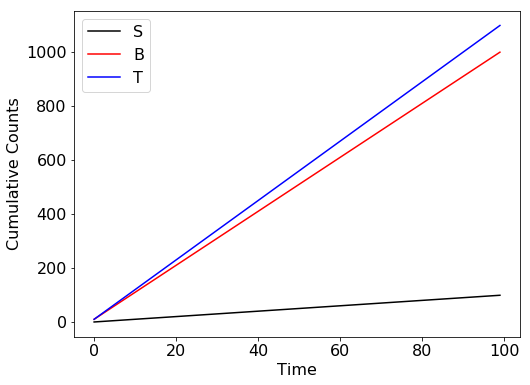

In [1104]:
plt.plot(S,label='S')
plt.plot(B,label='B')
plt.plot(T,label='T')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Counts')

<h3>A rough (and often wrongly used) approximation of the maximum signal strength ("significance") is provided by calculating the expectation value of the signal versus its standard deviation. For Poisson distributed data, the expectation value is calculated by the infinite sum $E(d) = \sum_{d=0}^{\infty} d \frac{m^d \exp(-m)}{d!} = m$ (Check if you can calculate that). The variance, i.e. the square of the standard deviationi, is given by $E(d^2) - E(d)^2 = m$, so that the standard deviation $\sigma = \sqrt{m}$. Finally, the signal-to-noise ratio of a "pure" signal is given by $m/\sqrt{m} = \sqrt{m}$, which means the increase in confidence in any signal rises with the square-root of time (for a constant rate).<br>We plot:</h3>

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'SNR')

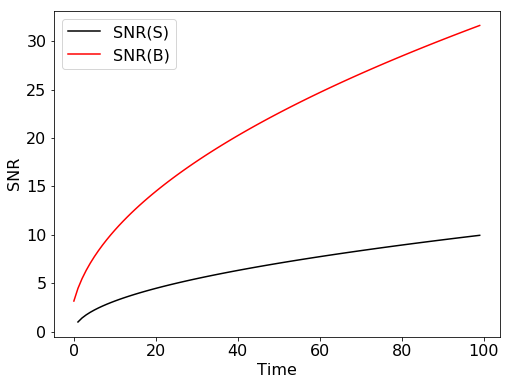

In [1107]:
plt.plot(S/np.sqrt(S),label='SNR(S)')
plt.plot(B/np.sqrt(B),label='SNR(B)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SNR')

<h3>When we could decide which photons came from the sky and which from the background, we would readily ignore the backgrorund ones and only take the sky as our measurement. But since we have to deal with both, and we are only interested in the sky, we can estimate the signal strength from the variance of the total counts, rather than only the sky counts, thus "significance" = $S/\sqrt{T}$:</h3>

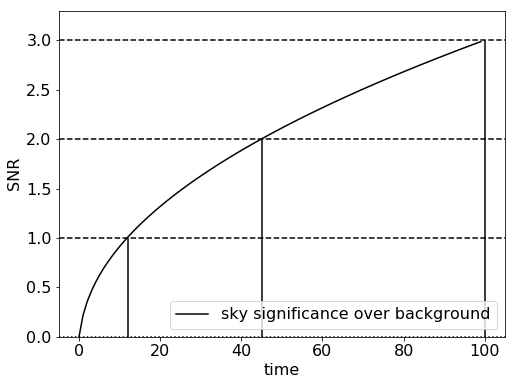

In [1123]:
plt.plot(S/np.sqrt(T),label='sky significance over background')
plt.axhline(1,linestyle='--')
plt.vlines(12,0,1) # we get ~1sigma after 11 time bins (+1 for the zeroth entry)
plt.axhline(2,linestyle='--')
plt.vlines(45,0,2) # to get ~2sigma, i.e. double the significance, we need to quadruple the time
# thus 4*11 = 44 (+1 for the zeroth entry)
plt.axhline(3,linestyle='--')
plt.vlines(100,0,3) # to get ~3sigma, i.e. triple the significance, we need to ninetuple(?) the time
# thus 9*11 = 99 (+1 for the zeroth entry)
plt.xlabel('time')
plt.ylim(0,3.3)
plt.axhline(0,linestyle=':')
plt.ylabel('SNR')
plt.legend()

<h5>We will our fit now more than onc to see how our 'signal-to-noise-ratio' increases with increasing observation time (number of pointings):</h5>

In [1124]:
n_arr = np.array([1,3,5,10,30,50,100,300,500,1000,3000,5000])

<h5>Number of tested data sets:</h5>

In [1125]:
n_test = len(n_arr)

<h5>Empty arrays to save our fluxes and uncertainties in:</h5>

In [1126]:
fitted_fluxes = np.zeros(n_test)
fitted_fluxes_err = np.zeros(n_test)

<h5>Loop over increasing number of pointings in data set:</h5>

In [1128]:
for n in range(n_test):

    Np = n_arr[n]
    p = np.arange(Np)
    
    true_sky = 1.25e-3
    true_bg = 30.

    y_true = true_sky*R_SKY(p) + true_bg*R_BG(p)
    yt = np.random.poisson(y_true)
    
    Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
    N = Np*Nrsp                      # total number of data points

    mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
    # this has to be an array because it could be more than one
    sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
    mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
    sigma_Abg = 30.                  # same


    # background cuts (here only one parameter for all times)
    bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np)

    # dictionary for data set and prior
    data2D = dict(N = Nrsp,
                  Np = Np,
                  Nsky = 1,
                  Ncuts = Ncuts,
                  bg_cuts = bg_cuts,
                  bg_idx_arr = idx_arr,
                  y = yt.ravel().astype(int),
                  bg_model = R_BG(p),
                  conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
                  mu_flux = mu_flux_scl,
                  sigma_flux = sigma_flux_scl,
                  mu_Abg = mu_Abg,
                  sigma_Abg = sigma_Abg)
    
    op2 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True,pars=['flux','Abg'])
    
    fitted_fluxes[n] = np.mean(op2['flux'])
    fitted_fluxes_err[n] = np.std(op2['flux'])

<h5>This can take a while since we are fitting a lot of data points (still nowhere near the real SPI data</h5>

<h5>Plot our results:</h5>

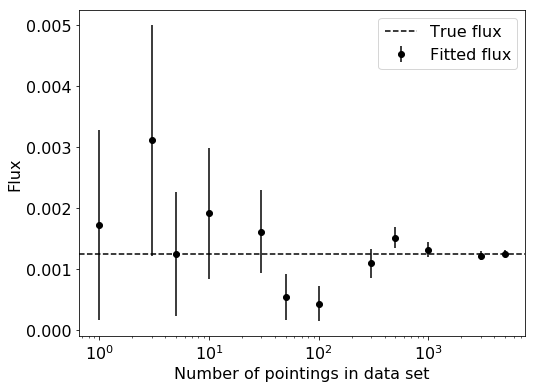

In [1129]:
plt.errorbar(n_arr,fitted_fluxes,yerr=fitted_fluxes_err,marker='o',linestyle='',label='Fitted flux')
plt.xscale('log')
plt.axhline(true_sky,linestyle='--',label='True flux')
plt.xlabel('Number of pointings in data set')
plt.ylabel('Flux')
plt.legend()

<h5>Finally, signal-to-noise ratio, plus (approximation of) expected increase:</h5>

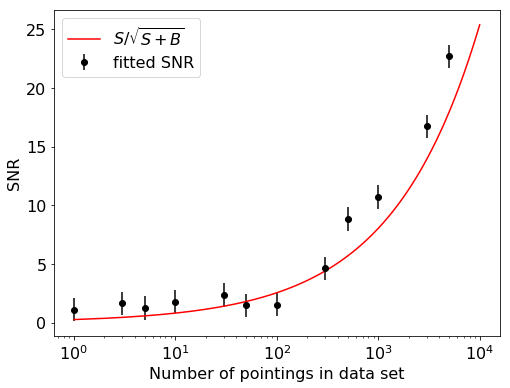

In [1130]:
plt.errorbar(n_arr,fitted_fluxes/fitted_fluxes_err,
             marker='o',linestyle='',yerr=np.repeat(1,len(n_arr)),label='fitted SNR')
nn = np.arange(1,10000)
plt.plot(nn,np.sqrt(nn)*2/np.sqrt(62),label=r'$S/\sqrt{S+B}$')
# note the factor 2/sqrt(2) comes from the expectation value in one pointing, here
# (30 + 30) for backround + (0 + 2) for sky as the total counts, but distributed 
# across 2 detectors which are to be taken as individual units.
plt.xscale('log')
#plt.xlim(500,5000)
plt.xlabel('Number of pointings in data set')
plt.ylabel('SNR')
plt.legend()

<h3>Now we want to include the exponential decay or our sources because we know when they explode and behave as function of time. So, instead of having a constant source, we apply an exponential decay function, starting at a certain time, to our response. Consider the following plot:</h3>

In [1132]:
Np = 100
p = np.arange(Np)

(-0.1, 6.5)

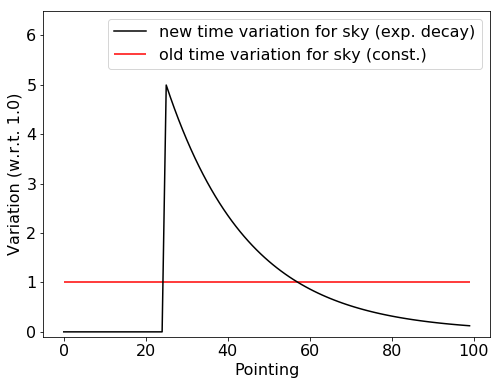

In [1140]:
true_T0 = 25
true_tau = 20
plt.plot(p,np.exp(-(p-true_T0)/true_tau)*np.heaviside(p-true_T0,1)/np.mean(np.exp(-(p-true_T0)/true_tau)*np.heaviside(p-true_T0,1)),
         label='new time variation for sky (exp. decay)')
plt.hlines(1,0,99,
           color='red',label='old time variation for sky (const.)')
plt.legend()
plt.xlabel('Pointing')
plt.ylabel('Variation (w.r.t. 1.0)')
plt.ylim(-0.1,6.5)

<h3>Clearly, if we used the red line if we actually expected the black, we overestimate the flux from 0 to 25, underestimate between 25 and ~55, and then overestimate again. The two lines are scaled to each other, meaning, the have the same area under the curve over this plotting range, so that they would predict the same number of photons in the same time between 0 and 100. But the absolute flux for the black curve is in fact a factor ~5 larger compared to the red one.</h3>

<h3>Exponential decay included in response:</h3>

In [1141]:
def R_SKY_expdecay(p,T0,tau): # pointing p
    A_eff = 10.
    T_p = 100.
    return A_eff*T_p*np.array([1+(-1)**(p+1),1+(-1)**(p)]).T*(np.exp(-(p-T0)/tau)*np.heaviside(p-T0,1))[:,None]

<h3>Now same things as above: creation of a data set, sampling, fitting, comparison to true values, assessment of fitting quality.</h3>

In [1145]:
true_sky = 2e-3 # ph / cm2 / s
true_bg = 10   # counts
true_T0 = 25
true_tau = 20

y_true = true_sky*R_SKY_expdecay(p,true_T0,true_tau) + true_bg*R_BG(p)
yp = np.random.poisson(y_true)

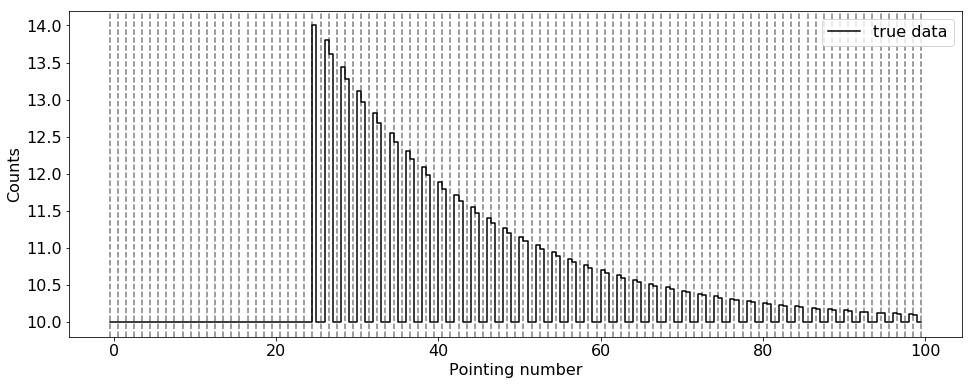

In [1146]:
plt.figure(figsize=(16,6))
SPIl_plot(p,
          y_true,color='black',label='true data')

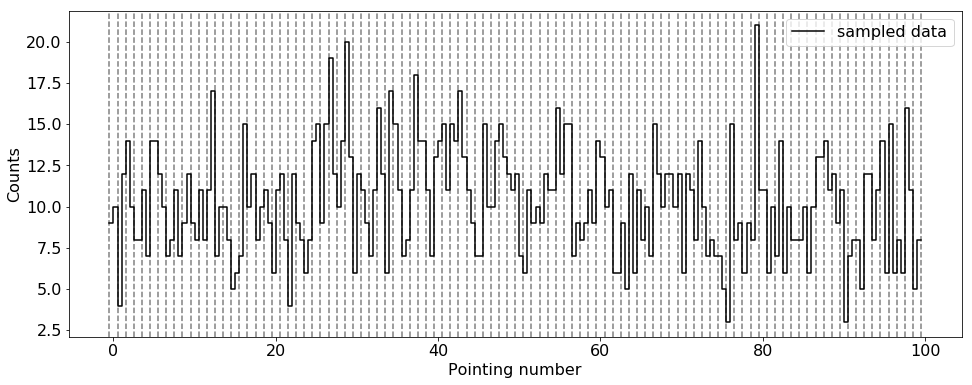

In [1147]:
plt.figure(figsize=(16,6))
SPIl_plot(p,
          yp,color='black',label='sampled data')

In [1148]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],len(p)) # for 10 pointings, use only one time node (== constant BG)
# (python's first index is zero, Stan's is 1 (!))

Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY_expdecay(p,true_T0,true_tau).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [1149]:
op4 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg'])

In [1150]:
print(op4.stansummary(['flux','Abg']))

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 2.7e-3  1.9e-5 6.3e-4 1.5e-3 2.3e-3 2.7e-3 3.1e-3 3.9e-3   1127    1.0
Abg[1]    9.73  7.3e-3   0.25   9.25   9.56   9.74   9.91   10.2   1159    1.0

Samples were drawn using NUTS at Fri Jul 17 22:40:19 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


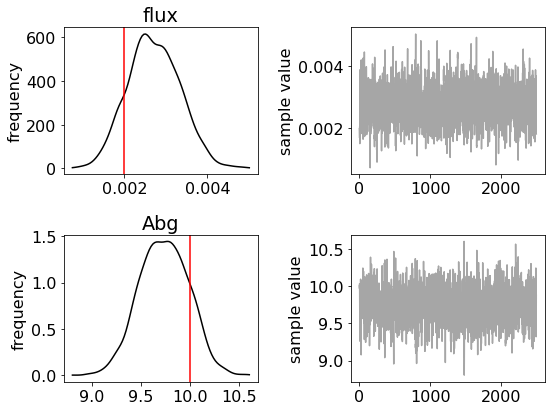

In [1151]:
test = op4.plot(['flux','Abg']);
test.get_axes()[0].axvline(true_sky,color='red')
test.get_axes()[2].axvline(true_bg,color='red')
plt.tight_layout()

In [1152]:
pp = np.sort(np.concatenate([p-0.5,p+0.5])) # array for plotting

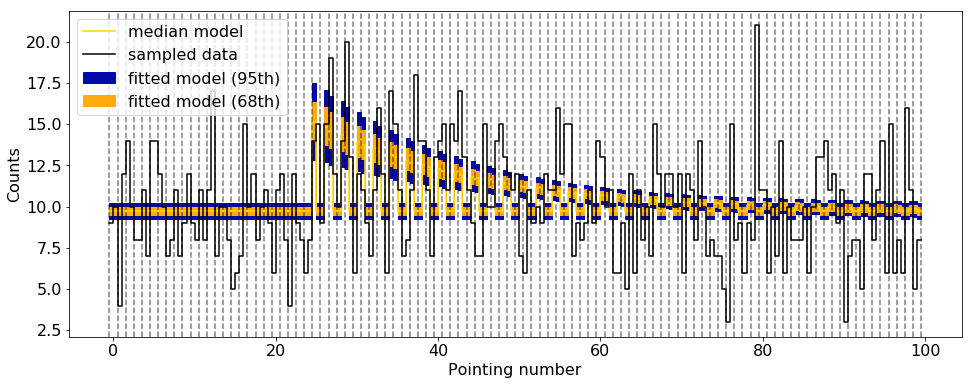

In [1153]:
plt.figure(figsize=(16,6))

plt.step(pp,np.percentile(op4['model_values'],50,axis=0),color='gold',where='mid',label='median model')

plt.fill_between(pp,
         np.percentile(op4['model_values'],50-95.4/2,axis=0),
         np.percentile(op4['model_values'],50+95.4/2,axis=0),
                 step='mid',color='xkcd:cobalt blue',alpha=1.0,label='fitted model (95th)')

plt.fill_between(pp,
         np.percentile(op4['model_values'],50-68.3/2,axis=0),
         np.percentile(op4['model_values'],50+68.3/2,axis=0),
                 step='mid',color='xkcd:yellowish orange',alpha=1.0,label='fitted model (68th)')

SPIl_plot(p,
          yp,color='black',label='sampled data')

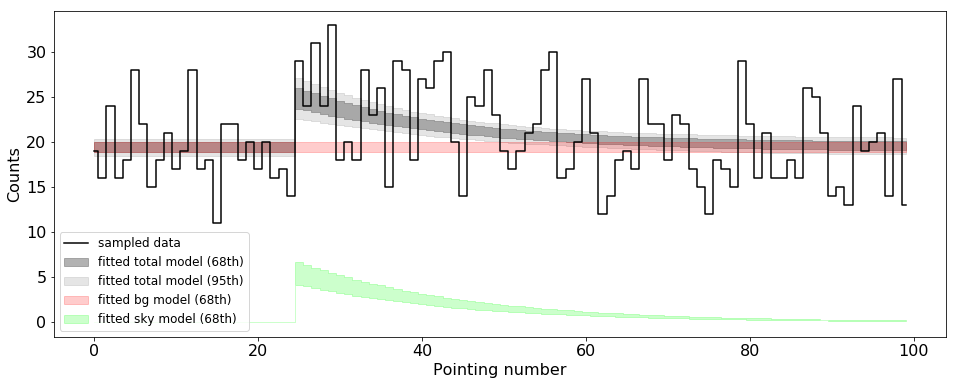

In [1154]:
plt.figure(figsize=(16,6))
plt.fill_between(p,
         np.percentile(op4['model_tot'],50-68.3/2,axis=0),
         np.percentile(op4['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op4['model_tot'],50-95.4/2,axis=0),
         np.percentile(op4['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op4['model_bg'],50-68.3/2,axis=0),
         np.percentile(op4['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op4['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op4['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=0,fontsize=12)

<h3>Looking good, I suppose.</h3>

<h3>And the counter-example of using the wrong time profile for the sources:</h3>

In [1155]:
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],len(p)) # for 10 pointings, use only one time node (== constant BG)
# (python's first index is zero, Stan's is 1 (!))

Np, Nrsp = R_BG(p).shape         # initialise sizes of arrays
N = Np*Nrsp                      # total number of data points

mu_flux_scl = np.array([10.])    # prior centroids for sky, we use 10 because we are ignorant;
# this has to be an array because it could be more than one
sigma_flux_scl = np.array([10.]) # same for the width (so, easily 0 but also high values possible)
mu_Abg = 30.                     # for the moment set to a useful value (because we didn't do anything else, yet)
sigma_Abg = 30.                  # same


# background cuts (here only one parameter for all times)
bg_cuts, idx_arr, Ncuts = make_bg_cuts([],Np)

# dictionary for data set and prior
data2D = dict(N = Nrsp,
              Np = Np,
              Nsky = 1,
              Ncuts = Ncuts,
              bg_cuts = bg_cuts,
              bg_idx_arr = idx_arr,
              y = yp.ravel().astype(int),
              bg_model = R_BG(p),
              conv_sky = R_SKY(p).reshape(1,Np,Nrsp), # this has to be reshaped because it could be more than one
              mu_flux = mu_flux_scl,
              sigma_flux = sigma_flux_scl,
              mu_Abg = mu_Abg,
              sigma_Abg = sigma_Abg)

In [1156]:
op5 = model.sampling(data=data2D,chains=1,iter=5000,n_jobs=-1,verbose=True)#,pars=['flux','Abg'])

In [1157]:
print(op5.stansummary(['flux','Abg']))

Inference for Stan model: anon_model_c2e0aba85727555652db8ac183ad91d8.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
flux[1] 2.9e-4  6.6e-6 1.7e-4 1.9e-5 1.5e-4 2.8e-4 4.0e-4 6.6e-4    682    1.0
Abg[1]    9.99    0.01   0.28   9.44    9.8   10.0  10.19  10.53    680    1.0

Samples were drawn using NUTS at Fri Jul 17 22:41:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


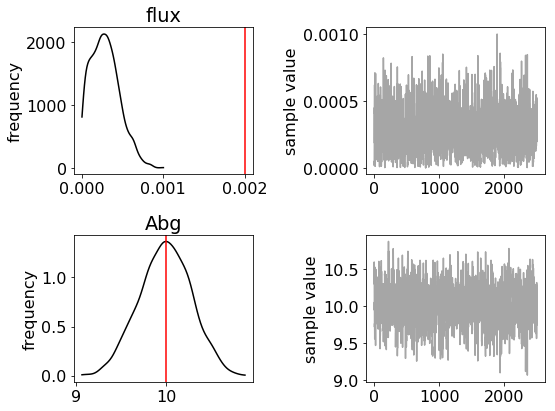

In [1158]:
test = op5.plot(['flux','Abg']);
test.get_axes()[0].axvline(true_sky,color='red')
test.get_axes()[2].axvline(true_bg,color='red')
plt.tight_layout()

<h3>Clearly, the flux is way off the true value, even though we fit the background perfectly. By ignoring the physics (here, time variation of the source), we lose sensitivity and won't learn much from the fit, as shown below. Note, however, that the flux has a smaller(!) uncertainty in this case, which we would consider to be a good thing, but actually find a wrong answer by "improving" the uncertainty.</h3>

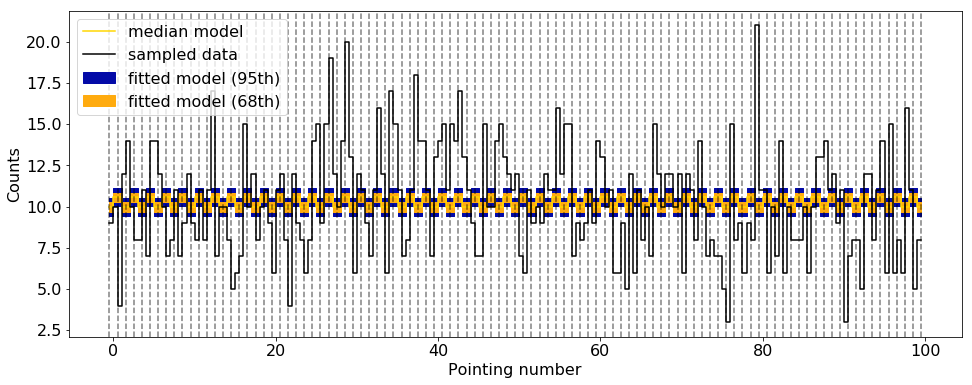

In [1159]:
plt.figure(figsize=(16,6))

plt.step(pp,np.percentile(op5['model_values'],50,axis=0),color='gold',where='mid',label='median model')

plt.fill_between(pp,
         np.percentile(op5['model_values'],50-95.4/2,axis=0),
         np.percentile(op5['model_values'],50+95.4/2,axis=0),
                 step='mid',color='xkcd:cobalt blue',alpha=1.0,label='fitted model (95th)')

plt.fill_between(pp,
         np.percentile(op5['model_values'],50-68.3/2,axis=0),
         np.percentile(op5['model_values'],50+68.3/2,axis=0),
                 step='mid',color='xkcd:yellowish orange',alpha=1.0,label='fitted model (68th)')

SPIl_plot(p,
          yp,color='black',label='sampled data')

<h3>Optical illusion? The line doesn't go up.</h3>

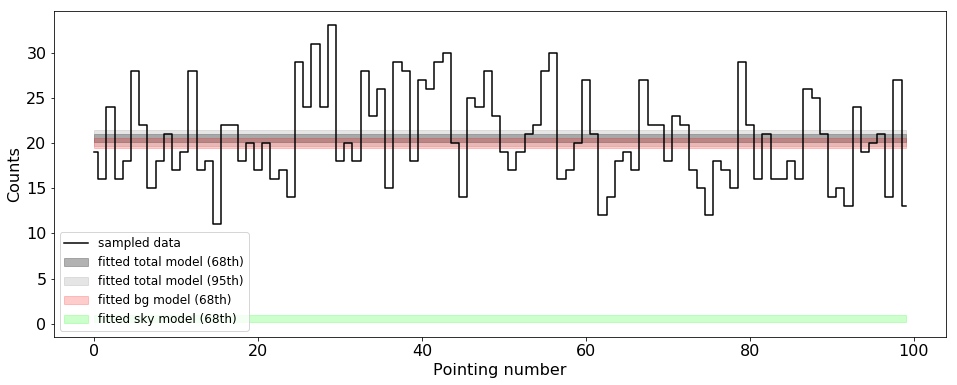

In [1160]:
plt.figure(figsize=(16,6))
plt.fill_between(p,
         np.percentile(op5['model_tot'],50-68.3/2,axis=0),
         np.percentile(op5['model_tot'],50+68.3/2,axis=0),step='mid',color='gray',alpha=0.6,label='fitted total model (68th)')
plt.fill_between(p,
         np.percentile(op5['model_tot'],50-95.4/2,axis=0),
         np.percentile(op5['model_tot'],50+95.4/2,axis=0),step='mid',color='gray',alpha=0.2,label='fitted total model (95th)')
plt.fill_between(p,
         np.percentile(op5['model_bg'],50-68.3/2,axis=0),
         np.percentile(op5['model_bg'],50+68.3/2,axis=0),step='mid',color='red',alpha=0.2,label='fitted bg model (68th)')
plt.fill_between(p,
         np.percentile(op5['model_sky'],50-68.3/2,axis=(0,1)),
         np.percentile(op5['model_sky'],50+68.3/2,axis=(0,1)),step='mid',color='lime',alpha=0.2,label='fitted sky model (68th)')

plt.step(p,np.sum(yp,axis=1),color='black',label='sampled data',where='mid')

plt.xlabel('Pointing number')
plt.ylabel('Counts')
plt.legend(loc=0,fontsize=12)